In [9]:
# Author: Syed (codefather)
# Date: 2024-05-28

import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
import os
import time
from os.path import join
from pycromanager import Core, start_headless, stop_headless

# creating required directories
os.makedirs('Autofocus', exist_ok=True)
os.makedirs('Stitches', exist_ok=True)

# core should be global - to be fixed later
mm_app_path = "C:\\Program Files\\Micro-Manager-2.0"
config_file = "C:\\Program Files\\Micro-Manager-2.0\\IX81_LUDL_amscope_Laser532.cfg"
print("before")
# stop_headless()
# Start the headless process
start_headless(mm_app_path, config_file, debug=False)
# time.sleep(1)
print("after")
core = Core()
print(core)
core.load_system_configuration(config_file)
print("loaded")

before
after
loaded


0 z-position: 1310
1 z-position: 1311
2 z-position: 1312
3 z-position: 1313
4 z-position: 1314
5 z-position: 1315
6 z-position: 1316
7 z-position: 1317
8 z-position: 1318
9 z-position: 1319
10 z-position: 1320
11 z-position: 1321
12 z-position: 1322
13 z-position: 1323
14 z-position: 1324
15 z-position: 1325
16 z-position: 1326
17 z-position: 1327
18 z-position: 1328
19 z-position: 1329
20 z-position: 1330
21 z-position: 1331
22 z-position: 1332
23 z-position: 1333
24 z-position: 1334
25 z-position: 1335
26 z-position: 1336
27 z-position: 1337
28 z-position: 1338
29 z-position: 1339
30 z-position: 1340
31 z-position: 1341
32 z-position: 1342
33 z-position: 1343
34 z-position: 1344
35 z-position: 1345
36 z-position: 1346
37 z-position: 1347
38 z-position: 1348
39 z-position: 1349
40 z-position: 1350
41 z-position: 1351
0 249.2780024210612 2.2573075006431793 0.020440781388536392
1 249.30493958791098 2.1244637478932265 0.018103717574039557
2 249.4679266611735 0.9807154521719873 0.00385541

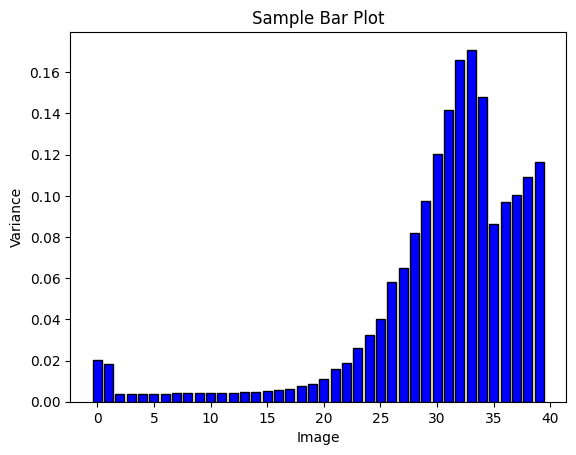

In [10]:
#%% Autofocus_WS_plane
variances = []
index = []

def autofocus_plane(core:Core=None, path="", n_images=60, z_start=1340) -> None:
    # Record images along z axis
    core.set_property("TransmittedLamp", "Label", "On")
    core.set_camera_device("AmScope")
    camera_name = core.get_camera_device()
    core.set_property(camera_name, "Binning", "1x1")
    core.set_property(camera_name, "PixelType", "GREY8")
    core.set_property(camera_name, "ExposureAuto", "0")
    core.set_exposure(15)

    # core.set_serial_port_command("COM13", "CURRENT=0", "\r\n")
    
    width = core.get_image_width()
    height = core.get_image_height()
    byte_depth = core.get_bytes_per_pixel()
    xystage = core.get_xy_stage_device()
    zstage = core.get_focus_device()

    core.set_position(zstage, z_start)
    time.sleep(2)
    pos = {'z': core.get_position(zstage)}
    nz = n_images  # number of images 
    step = 1
    # pos['z'] -= nz * 0.5 * step

    for a in range(z_start-n_images//2, z_start+2+n_images//2, step):
        core.snap_image()
        # core.snap_image()
        # time.sleep(0.05)
        img = core.get_image()
        
        if byte_depth == 1:
            ip = np.reshape(img, (height, width)).astype(np.uint8)
        elif byte_depth == 2:
            ip = np.reshape(img, (height, width)).astype(np.uint16)
        elif byte_depth == 4:
            ip = np.reshape(img, (height, width)).astype(np.uint32)
        else:
            raise ValueError(f'byte depth should be 1, 2 or 4. byte depth: {byte_depth}')
        
        img_index = a - z_start + n_images//2

        if img_index == 0 or img_index == 1:
            pre_path = join(path, f"Autofocus/image_{img_index}.tif")
        else:
            pre_path = join(path, f"Autofocus/image_{img_index-2}.tif")

        # ip = ip[:1000, 0:1180]
        
        tiff.imwrite(pre_path, ip, photometric='minisblack')
        pos['z'] = a
        core.set_position(zstage, pos['z'])
        print(img_index, "z-position:", pos['z'])
        # time.sleep(0.05)
    
    # pos['z'] = z_start
    # core.set_position(zstage, pos['z'])

    max_var, max_var_index = -1, -1
    for i in range(nz):
        image = tiff.imread(join(path, f"Autofocus/image_{i}.tif"))
        mean, std = np.mean(image), np.std(image)
        norm_var = std * std / mean
        print(i, mean, std, norm_var)
        variances.append(norm_var)
        index.append(i)
        if norm_var > max_var:
            max_var, max_var_index = norm_var, i
    
    pos['z'] = (z_start-n_images//2) + (step * max_var_index)
    core.set_position(zstage, pos['z'])
    print("z-position:", pos['z'], core.get_position(zstage))
    return max_var_index, max_var

max_i, max_var = autofocus_plane(core, n_images = 40, z_start=1330)
print(max_i, max_var)

plt.bar(index, variances, color='blue', edgecolor='black')
plt.title('Sample Bar Plot')
plt.xlabel('Image')
plt.ylabel('Variance')
plt.show()

In [ ]:
#%% image_grid -> cell_filter_isolation

def capture_image_grid(core:Core=None, path:str="", rows:int=4, cols:int=5) -> None:
    width = core.get_image_width()
    height = core.get_image_height()
    byte_depth = core.get_bytes_per_pixel()
    camera_name = core.get_camera_device()

    # core.set_property(camera_name, "Binning", "1x1")
    # core.set_property(camera_name, "PixelType", "GREY8")
    # core.set_property(camera_name, "ExposureAuto", "0")
    # core.set_exposure(25)

    xystage = core.get_xy_stage_device()
    pos_x = core.get_x_position(xystage)
    pos_y = core.get_y_position(xystage)

    x_origin = pos_x
    y_origin = pos_y

    # Grid settings
    n, m = cols, rows  
    inc_x = 320  # step size in X direction
    inc_y = 240  # step size in Y direction

    pos_x = pos_x - inc_x * (0.5 * n - 0.5)
    pos_y = pos_y - inc_y * (0.5 * m - 0.5)
    startx, starty = pos_x, pos_y
    cc = 0

    # core.set_xy_position(pos_x, pos_y)
    time.sleep(1)

    for a in range(m):
        for b in range(n):
            pos_x = startx + inc_x * b
            pos_y = starty + inc_y * a

            # core.set_xy_position(pos_x, pos_y)
            # time.sleep(0.5)
            core.snap_image()
            # core.snap_image()
            # time.sleep(0.5)

            img = core.get_image()

            if byte_depth == 1:
                ip = np.reshape(img, (height, width)).astype(np.uint8)
            elif byte_depth == 2:
                ip = np.reshape(img, (height, width)).astype(np.uint16)
            else:
                raise ValueError(f'byte depth should be 1 or 2. byte depth: {byte_depth}')

            pre_path = os.path.join(path, f"Stitches/imageXY-{cc}.tif")
            tiff.imwrite(pre_path, ip, photometric='minisblack')
            cc += 1

    # core.set_xy_position(x_origin, y_origin)


capture_image_grid(core)

In [ ]:
import cv2
from skimage.feature import peak_local_max
from skimage import io, img_as_ubyte


def stitch_images(core:Core=None, path:str="", rows:int=4, cols:int=5) -> None:
    n, m = cols, rows 
    input_dir = os.path.join(path, "Stitches")
    image_files = [os.path.join(input_dir, f"imageXY-{i}.tif") for i in range(0, n * m)]
    stitched_image_rows = []

    # stitching all images by row
    for row in range(m):
        stitched_row = None
        for col in range(n):
            image_file = image_files[row*n + col]
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            if stitched_row is None:
                stitched_row = image
            else:
                stitched_row = np.hstack((stitched_row, image))
        stitched_image_rows.append(stitched_row)

    stitched_image = np.vstack(stitched_image_rows)
    stitched_image_path = os.path.join(input_dir, "stitchedImage.tif")
    cv2.imwrite(stitched_image_path, stitched_image)

    stitched_image = img_as_ubyte(stitched_image) # converting to 8-bit unsigned

    # finding maxima
    coordinates = peak_local_max(stitched_image, min_distance=20, threshold_abs=35)

    # saving cell positions
    result_file = os.path.join(input_dir, "cell_positions.txt")
    with open(result_file, 'w') as f:
        for coord in coordinates:
            f.write(f"{coord[1]},{coord[0]}\n")
    
stitch_images(core)